## Description

This notebook calculates the LAT spacecraft zenith direction given the spacecraft file and uses it to compute the zenith angles of the recorded events. As a sanity check, the results are compared against the values provided by the LAT team.

In [2]:
import logging
import astropy.units as u

from astropy.io import fits
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.coordinates.erfa_astrom import erfa_astrom, ErfaAstromInterpolator

from matplotlib import pyplot

In [3]:
def read_ref_time(file_name):
    with fits.open(file_name) as hdus:
        ref_time = Time(
            hdus['Primary'].header['MJDREFI'] + hdus['Primary'].header['MJDREFF'],
            format='mjd',
            scale=hdus['Primary'].header['TIMESYS'].lower()
        )
        
    return ref_time

In [4]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s  %(name)s : %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
)
log = logging.getLogger('main')

## Download data
Data set is a single weekly LAT spacecraft file and the corresponding photon one. The total file size to download is ~40 Mb.

In [8]:
!curl https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly/1s_spacecraft/lat_1sec_spacecraft_weekly_w009_p310_v001.fits -o lat_1sec_spacecraft_weekly_w009_p310_v001.fits

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26.2M  100 26.2M    0     0  1916k      0  0:00:14  0:00:14 --:--:-- 2133k


In [9]:
!curl https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly/photon/lat_photon_weekly_w009_p305_v001.fits -o lat_photon_weekly_w009_p305_v001.fits

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.0M  100 16.0M    0     0  1679k      0  0:00:09  0:00:09 --:--:-- 2157k


## Read data files

Spacecraft file is processed with the `LatSpacecraft` class from "latsc.py" that converts spacecraft position to an `EarthLocation` instance.

In [10]:
from latsc import LatSpacecraft

In [11]:
sc = LatSpacecraft(
    'lat_1sec_spacecraft_weekly_w009_p310_v001.fits',
    log=log
)

In [12]:
events = Table.read(
    'lat_photon_weekly_w009_p305_v001.fits',
    format='fits',
    hdu='events'
)

## Compute event zenith angles

In [13]:
evt_coord = SkyCoord(
    events['RA'],
    events['DEC'],
    unit='deg',
    frame='fk5'
)

Convert events observation time to astropy's `Time` accounting for the zero point defined in the FITS file.

In [14]:
ref_time = read_ref_time('lat_photon_weekly_w009_p305_v001.fits')
obstime = Time(
    events['TIME'] + ref_time.gps,
    format='gps',
    scale='utc'
)

Calculate spacecraft zenith direction at that time. `LatSpacecraft` class performs linear interpolation of the zenith RA/Dec at the moments spacefied in the spacecraft file to those of the events. 

Given the 1 sec step of the spacecraft file and roughly 1.5 hr orbit, expected accuracy should be better than `360 / (1.5*3600) ~ 0.07 deg`

In [15]:
sc_zenith = sc.sc_zenith(obstime)

Now compute events zenith / azimuthal angles and offset with respect to the reference values from the LAT files

In [16]:
with erfa_astrom.set(ErfaAstromInterpolator(0.1 * u.s)):
    evt_zenith_angle = evt_coord.separation(sc_zenith)
    evt_pos_angle = evt_coord.position_angle(sc_zenith)

In [17]:
offset = evt_zenith_angle.deg - events['ZENITH_ANGLE']

## Compare results

Comparying the results for the first 10000 events. Difference w.r.t to the reference is scattered within ~0.15 deg and is clearly correlated with events' azimuth angle.

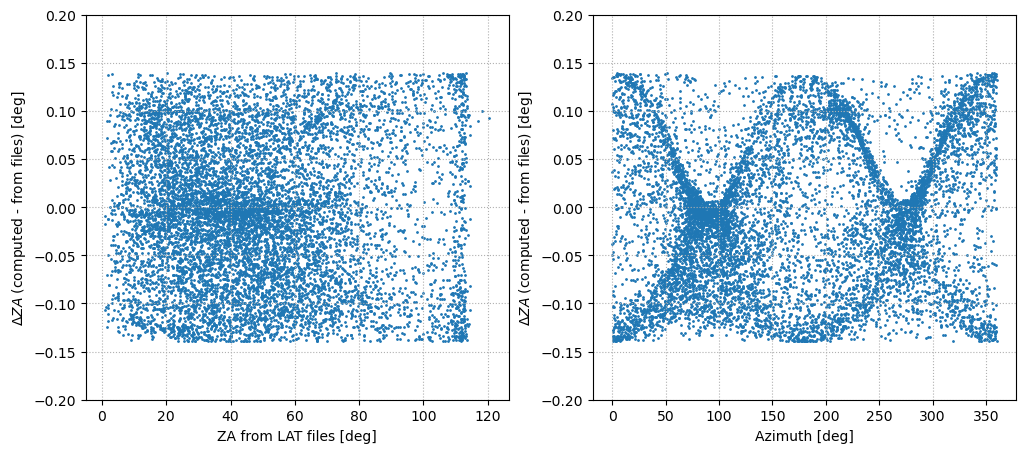

In [18]:
pyplot.figure(figsize=(12, 5))

n = 10000

pyplot.subplot(121)
pyplot.xlabel('ZA from LAT files [deg]')
pyplot.ylabel(r'$\Delta ZA$ (computed - from files) [deg]')
pyplot.scatter(
    events['ZENITH_ANGLE'][:n],
    offset[:n],
    marker='o',
    s=1,
)
pyplot.ylim(-0.2, 0.2)
pyplot.grid(linestyle=':')

pyplot.subplot(122)
pyplot.xlabel('Azimuth [deg]')
pyplot.ylabel(r'$\Delta ZA$ (computed - from files) [deg]')
pyplot.scatter(
    evt_pos_angle.deg[:n],
    offset[:n],
    marker='o',
    s=1
)
pyplot.ylim(-0.2, 0.2)
pyplot.grid(linestyle=':')

## Recalc without using latsc.py

In [19]:
# Define the Haversine formula - angle (in degrees) between 2 vectors in spherical coords
import numpy as np

def haversine(azi1, alt1, azi2, alt2):
    """
    Calculate the great circle distance between two points 
    """
    # convert decimal degrees to radians 
    azi1, alt1, azi2, alt2 = map(np.deg2rad, [azi1, alt1, azi2, alt2])

    # haversine formula 
    dlon = azi2 - azi1
    dlat = alt2 - alt1
    a = np.sin(dlat/2)**2 + np.cos(alt1) * np.cos(alt2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return np.rad2deg(c)

In [26]:
scdata = Table.read(
    'lat_1sec_spacecraft_weekly_w009_p310_v001.fits',
    format='fits',
    hdu='SC_DATA'
)

In [27]:
zenithInterp = []
zenithDiff = []
for photon in events[:10000]:
    scRA = np.interp(photon['TIME'],scdata['START'],scdata['RA_ZENITH'])
    scDEC = np.interp(photon['TIME'],scdata['START'],scdata['DEC_ZENITH'])
    hav = haversine(photon['RA'],photon['DEC'],scRA,scDEC)
    diff = photon['ZENITH_ANGLE'] - hav
    zenithDiff.append(diff)
    zenithInterp.append(hav)

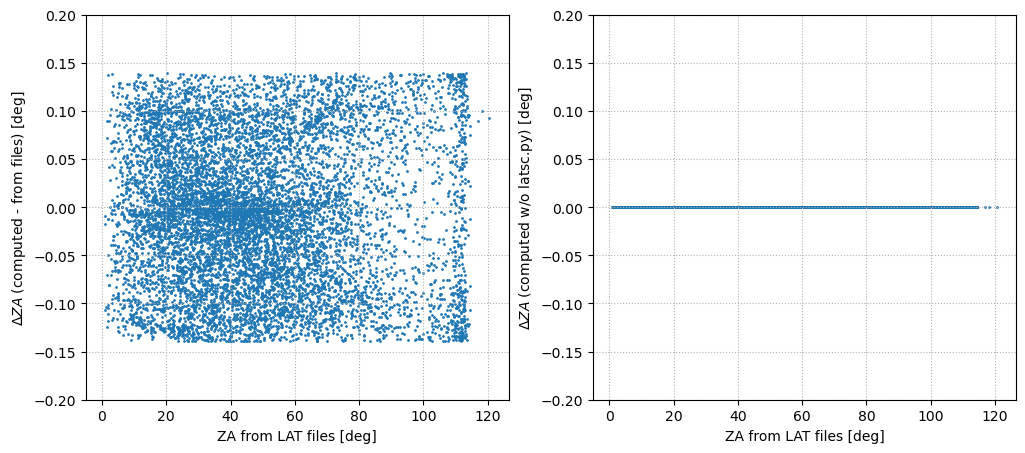

In [28]:
pyplot.figure(figsize=(12, 5))

n = 10000

pyplot.subplot(121)
pyplot.xlabel('ZA from LAT files [deg]')
pyplot.ylabel(r'$\Delta ZA$ (computed - from files) [deg]')
pyplot.scatter(
    events['ZENITH_ANGLE'][:n],
    offset[:n],
    marker='o',
    s=1,
)
pyplot.ylim(-0.2, 0.2)
pyplot.grid(linestyle=':')

pyplot.subplot(122)
pyplot.xlabel('ZA from LAT files [deg]')
pyplot.ylabel(r'$\Delta ZA$ (computed w/o latsc.py) [deg]')
pyplot.scatter(
    events['ZENITH_ANGLE'][:10000],
    zenithDiff,
    marker='o',
    s=1
)
pyplot.ylim(-0.2, 0.2)
pyplot.grid(linestyle=':')

In [30]:
# Compare the first 10 values of ZENITH_ANGLE in the photon file to those computed with latsc.py
print("events['ZENITH_ANGLE'] - evt_zenith_angle.deg = offset")
for i in range(10):
    fileval = events['ZENITH_ANGLE'][i]
    calcval = zenithInterp[i]
    diff = offset[i]
    print('%.8f'%fileval,'%.8f'%calcval,'%.15f'%diff)

events['ZENITH_ANGLE'] - evt_zenith_angle.deg = offset
70.46549988 70.46550350 -0.100263074363411
106.10063934 106.10064575 -0.083389075817564
96.35153961 96.35154075 -0.063069112228973
13.77798653 13.77798745 -0.100189683882554
52.98517227 52.98517962 -0.009669225107601
61.17519379 61.17519333 -0.086158909049075
39.31948471 39.31948452 -0.075388520539491
39.00677109 39.00677342 -0.098398482205411
29.06722260 29.06722384 -0.104499422476110
21.74608040 21.74608358 -0.104076490453885


In [29]:
# Compare the first 10 values of ZENITH_ANGLE in the photon file to those computed WITHOUT latsc.py
print("events['ZENITH_ANGLE'] - zenithInterp = zenithDiff]")
for i in range(10):
    fileval = events['ZENITH_ANGLE'][i]
    calcval = zenithInterp[i]
    diff = zenithDiff[i]
    print('%.8f'%fileval,'%.8f'%calcval,'%.15f'%diff)

events['ZENITH_ANGLE'] - zenithInterp = zenithDiff]
70.46549988 70.46550350 -0.000003623026799
106.10063934 106.10064575 -0.000006407521653
96.35153961 96.35154075 -0.000001135843561
13.77798653 13.77798745 -0.000000923419814
52.98517227 52.98517962 -0.000007343665054
61.17519379 61.17519333 0.000000455598439
39.31948471 39.31948452 0.000000189464117
39.00677109 39.00677342 -0.000002332660884
29.06722260 29.06722384 -0.000001246200792
21.74608040 21.74608358 -0.000003182783143
